# 

In [1]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
from jax.scipy.special import logsumexp
import genjax
from genjax import grasp
import matplotlib.pyplot as plt
from functools import reduce

In [2]:
console = genjax.pretty()

In [3]:
# from https://github.com/mattjj/svae/blob/master/experiments/gmm_svae_synth.py
def make_pinwheel_data(
    key, radial_std, tangential_std, num_classes, num_per_class, rate
):
    keys = jax.random.split(key, 2)
    rads = jnp.linspace(0, 2 * jnp.pi, num_classes, endpoint=False)

    features = jax.random.normal(keys[0], (num_classes * num_per_class, 2)) * jnp.array(
        [radial_std, tangential_std]
    )
    features = features.at[:, 0].add(1.0)
    labels = jnp.repeat(jnp.arange(num_classes), num_per_class)

    angles = rads[labels] + rate * jnp.exp(features[:, 0])
    rotations = jnp.stack(
        [jnp.cos(angles), -jnp.sin(angles), jnp.sin(angles), jnp.cos(angles)]
    )
    rotations = jnp.reshape(rotations.T, (-1, 2, 2))

    return 10 * jax.random.permutation(
        keys[1], jnp.einsum("ti,tij->tj", features, rotations)
    )

500


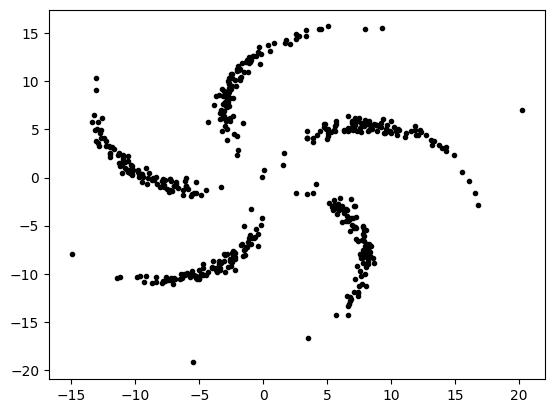

In [4]:
NUM_CLUSTERS = 5
POINTS_PER_CLUSTER = 100
N = NUM_CLUSTERS * POINTS_PER_CLUSTER
print(N)
pinwheel = make_pinwheel_data(
    jax.random.PRNGKey(0), 0.3, 0.05, NUM_CLUSTERS, POINTS_PER_CLUSTER, 0.25
)
plt.scatter(pinwheel[:, 0], pinwheel[:, 1], marker=".", c="black")

---

In [5]:
mlp = lambda x, ws: reduce(lambda z, w: jax.nn.leaky_relu(w @ z), ws, x)
matsqr = lambda x: x @ x
key = jax.random.PRNGKey(0)

In [6]:
@genjax.gen
def model(params):
    logits, means, scales, mean_ws, scale_ws = params
    z = grasp.categorical_enum(logits) @ "z"
    cluster_mean = jax.lax.dynamic_index_in_dim(means, z, keepdims=False)
    cluster_scale = jax.lax.dynamic_index_in_dim(scales, z, keepdims=False)
    x = grasp.mv_normal_reparam(cluster_mean, matsqr(cluster_scale)) @ "x"
    point_mean = mlp(x, mean_ws)
    point_scale = mlp(x, scale_ws).reshape(2, 2)
    grasp.mv_normal_reparam(point_mean, matsqr(point_scale)) @ "y"

In [7]:
model_params0 = (
    jnp.ones(NUM_CLUSTERS),  # logits
    jnp.arange(2 * NUM_CLUSTERS, dtype=jnp.float32).reshape(NUM_CLUSTERS, 2),  # means
    jnp.ones((NUM_CLUSTERS, 2, 2)),  # scales
    (
        jax.random.uniform(key, (10, 2)),
        jax.random.uniform(key, (10, 10)),
        jax.random.uniform(key, (10, 10)),
        jax.random.uniform(key, (2, 10)),
    ),  # mean_ws
    (
        jax.random.uniform(key, (10, 2)),
        jax.random.uniform(key, (10, 10)),
        jax.random.uniform(key, (10, 10)),
        jax.random.uniform(key, (4, 10)),
    ),  # scale_ws
)
model_params = model_params0

In [8]:
ch = model.simulate(key, (model_params,)).strip()
ch["z"], ch["x"], ch["y"]


(
    Array(2, dtype=int32),
    Array([4.0123134, 5.0122967], dtype=float32),
    Array([-163.33075, -213.26239], dtype=float32)
)

In [9]:
@genjax.gen
def variational_family(params, data):
    mean_ws, scale_ws, cat_ws = params
    cluster_mean = mlp(data["y"], mean_ws)
    cluster_scale = mlp(data["y"], scale_ws).reshape(2, 2)
    x = grasp.mv_normal_reparam(cluster_mean, matsqr(cluster_scale)) @ "x"
    z = grasp.categorical_enum(mlp(x, cat_ws)) @ "z"

In [10]:
vf_params0 = (
    (
        jax.random.uniform(key, (10, 2)),
        jax.random.uniform(key, (10, 10)),
        jax.random.uniform(key, (10, 10)),
        jax.random.uniform(key, (2, 10)),
    ),  # mean_ws
    (
        jax.random.uniform(key, (10, 2)),
        jax.random.uniform(key, (10, 10)),
        jax.random.uniform(key, (10, 10)),
        jax.random.uniform(key, (4, 10)),
    ),  # scale_ws
    (
        jax.random.uniform(key, (10, 2)),
        jax.random.uniform(key, (10, 10)),
        jax.random.uniform(key, (10, 10)),
        jax.random.uniform(key, (NUM_CLUSTERS, 10)),
    ),  # cat_ws
)
vf_params = vf_params0

In [11]:
pinwheel_data = genjax.choice_map({"y": pinwheel[0, :]})
ch = variational_family.simulate(key, (vf_params, pinwheel_data)).strip()
ch["x"], ch["z"]

(Array([-6.3091993e-06, -9.2071468e-06], dtype=float32), Array(4, dtype=int32))

In [12]:
def make_batched_loss_and_grad(model, vf):
    def loss_and_grad(key, datapoint, model_params, vf_params):
        data = genjax.choice_map({"y": datapoint})
        objective = grasp.elbo(model, vf, data)
        loss, ((model_grad,), (vf_grad, data)) = objective.value_and_grad_estimate(
            key, ((model_params,), (vf_params, data))
        )

        return (vf_grad, model_grad), loss

    def batched_loss_and_grad(key, batch, model_params, vf_params):
        mapped_loss_and_grad = jax.vmap(loss_and_grad, in_axes=(0, 0, None, None))
        keys = jax.random.split(key, len(batch))
        (vf_grads, model_grads), losses = mapped_loss_and_grad(
            keys, batch, model_params, vf_params
        )
        vf_grad = jtu.tree_map(lambda a: a.mean(axis=0), vf_grads)
        model_grad = jtu.tree_map(lambda a: a.mean(axis=0), model_grads)
        return vf_grad, model_grad, losses.mean()

    return batched_loss_and_grad

In [13]:
batched_loss_and_grad = jax.jit(make_batched_loss_and_grad(model, variational_family))

In [14]:
BATCH_SIZE = 20
NUM_EPOCHS = 5
LR = 1e-4
assert N % BATCH_SIZE == 0
for epoch in range(NUM_EPOCHS):
    perm = jax.random.permutation(key, pinwheel)
    losses = []
    for i in range(N // BATCH_SIZE):
        batch = perm[i * BATCH_SIZE : (i + 1) * BATCH_SIZE]
        vf_grad, model_grad, loss = batched_loss_and_grad(
            key, batch, model_params, vf_params
        )
        vf_params = jtu.tree_map(lambda p, g: p - LR * g, vf_params, vf_grad)
        model_params = jtu.tree_map(lambda p, g: p - LR * g, model_params, model_grad)
        key = jax.random.split(key)[0]
        losses.append(loss)
    print(f"Epoch {epoch} loss: {jnp.array(losses).mean()}")

Epoch 0 loss: nan
Epoch 1 loss: nan
Epoch 2 loss: nan
Epoch 3 loss: nan
Epoch 4 loss: nan


In [15]:
i = 0
model_params, vf_params = model_params0, vf_params0
batch = perm[i * BATCH_SIZE : (i + 1) * BATCH_SIZE]
vf_grad, model_grad, loss = batched_loss_and_grad(key, batch, model_params, vf_params)
# vf_params = jtu.tree_map(lambda p, g: p - LR * g, vf_params, vf_grad)
# model_params = jtu.tree_map(lambda p, g: p - LR * g, model_params, model_grad)
key = jax.random.split(key)[0]

In [16]:
model_grad


(
    Array([nan, nan, nan, nan, nan], dtype=float32),
    Array([[nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan]], dtype=float32),
    Array([[[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]]], dtype=float32),
    (
        Array([[nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan]], dtype=float32),
        Array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, na

In [17]:
vf_grad


(
    (
        Array([[nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan]], dtype=float32),
        Array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]], dtype=float32),
        Array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, na